Tutorial of 10X genomics data
===

VQTCR is a conditional vector quantization VAE framework for quantizing the functions of T cell receptors (TCR). 
- samples of 4 donors with paired scTCR-seq and scRNA-seq
- amini acid sequence of CDR3 on alpha chain and beta chain of TCR 
- data preprocessed following mvTCR pipeline


In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import scanpy as sc
import vqtcr as vt
vt.set_random_seed(3407)

In [2]:
path_base = '/mnt/d/Dataset/TCR/TCR-Donor1-4/'
path_data = path_base + 'v7_avidity.h5ad'

In [3]:
adata = sc.read(path_data)

In [4]:
adata, adata.obs['set'].value_counts()

(AnnData object with n_obs × n_vars = 128296 × 5000
     obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'barcode', 'don

In [5]:
adata.obs['donor']

AAACGGGAGAAGATTC-1-donor1    donor1
AAACGGGTCGGACAAG-1-donor1    donor1
AAAGATGGTACAGACG-1-donor1    donor1
AAAGTAGAGACGCTTT-1-donor1    donor1
AAAGTAGAGCGCTTAT-1-donor1    donor1
                              ...  
TTTGTCACATCAGTAC-8-donor4    donor4
TTTGTCAGTCTAAACC-8-donor4    donor4
TTTGTCAGTCTCTCGT-8-donor4    donor4
TTTGTCATCCCACTTG-8-donor4    donor4
TTTGTCATCTCTAAGG-8-donor4    donor4
Name: donor, Length: 128296, dtype: category
Categories (4, object): ['donor1', 'donor2', 'donor3', 'donor4']

In [6]:
hca = vt.HIGH_COUNT_ANTIGENS
# adata = adata[adata.obs['donor']=='donor2'] # ! test for donor 2
adata = adata[adata.obs['binding_name']!='no_data']
adata = adata[adata.obs['binding_name'].isin(hca)]

select 3000 hvgs

In [7]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
hvgs = adata.var_names[adata.var['highly_variable']]
adata = adata[:, hvgs]

/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:151: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": "seurat_v3"}


set model hyperparamters

In [8]:
params = vt.get_config()

Init the vqTCR, train_mode: ['semi_sup', 'unsup']

In [9]:
vqtcr = vt.vqTCR(params, adata, 
                 model_mode='semi_sup',
                 metadata=['clonotype'], 
                 sample_mode='clonotype',
                 conditional=None,
                 labels='binding_name')

/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [10]:
# print vqTCR model archtecture.
vqtcr.model

vqTCRModel(
  (alpha_encoder): TCREncoder(
    (embedding): Embedding(24, 64, padding_idx=0)
    (positional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=256, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
          (linear2): Linear(in_features=256, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.3, inplace=False)
          (dropout2): Dropout(p=0.3, inplace=False)
        )
      )
    )
    (fc_reduction): Linear(in_features=1664, out_features=64, bi

  0%|          | 0/100 [00:00<?, ?it/s]

EP[  10]: rna_loss=0.1218., tcr_loss=1.6534., vq_loss=0.0318., cls_loss=0.4960.
EP[  20]: rna_loss=0.1201., tcr_loss=1.2422., vq_loss=0.0515., cls_loss=0.1363.
EP[  30]: rna_loss=0.1205., tcr_loss=0.8601., vq_loss=0.0777., cls_loss=0.0683.
EP[  40]: rna_loss=0.1194., tcr_loss=0.5938., vq_loss=0.0891., cls_loss=0.0335.
EP[  50]: rna_loss=0.1212., tcr_loss=0.4302., vq_loss=0.0969., cls_loss=0.0181.
EP[  60]: rna_loss=0.1173., tcr_loss=0.3318., vq_loss=0.0986., cls_loss=0.0091.
EP[  70]: rna_loss=0.1169., tcr_loss=0.2651., vq_loss=0.1021., cls_loss=0.0143.
EP[  80]: rna_loss=0.1139., tcr_loss=0.2117., vq_loss=0.1031., cls_loss=0.0093.
EP[  90]: rna_loss=0.1152., tcr_loss=0.1781., vq_loss=0.1041., cls_loss=0.0042.
EP[ 100]: rna_loss=0.1146., tcr_loss=0.1416., vq_loss=0.0994., cls_loss=0.0050.


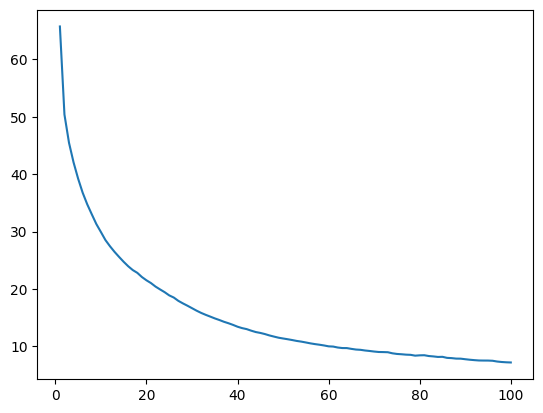

In [11]:
# training the model
vqtcr.train()

In [12]:
adata = vqtcr.eval_metric(adata, labels='binding_name')

rna_loss=0.0964., tcr_loss=0.9022., vq_loss=0.0731., cls_loss=0.4350.
rna_loss=0.1053., tcr_loss=0.9623., vq_loss=0.0751., cls_loss=0.4591.
rna_loss=0.0953., tcr_loss=0.6901., vq_loss=0.0652., cls_loss=0.4341.
rna_loss=0.0840., tcr_loss=0.5346., vq_loss=0.0583., cls_loss=0.2763.
rna_loss=0.0866., tcr_loss=0.5578., vq_loss=0.0589., cls_loss=0.2675.
rna_loss=0.0907., tcr_loss=0.5916., vq_loss=0.0612., cls_loss=0.3115.
rna_loss=0.0969., tcr_loss=0.5866., vq_loss=0.0621., cls_loss=0.3141.
rna_loss=0.1043., tcr_loss=0.6489., vq_loss=0.0655., cls_loss=0.3415.
rna_loss=0.0944., tcr_loss=0.6971., vq_loss=0.0642., cls_loss=0.3883.
rna_loss=0.1563., tcr_loss=1.2183., vq_loss=0.0976., cls_loss=0.3902.
rna_loss=0.1224., tcr_loss=1.2294., vq_loss=0.0873., cls_loss=0.3040.
rna_loss=0.0985., tcr_loss=1.2112., vq_loss=0.0797., cls_loss=0.2404.
rna_loss=0.1290., tcr_loss=1.1494., vq_loss=0.0892., cls_loss=0.3947.
rna_loss=0.1363., tcr_loss=1.2251., vq_loss=0.0915., cls_loss=0.5021.
rna_loss=0.1098., tc

/home/zl/vqTCR/vqtcr/vqtcr.py:138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['att'] = tcr_atts


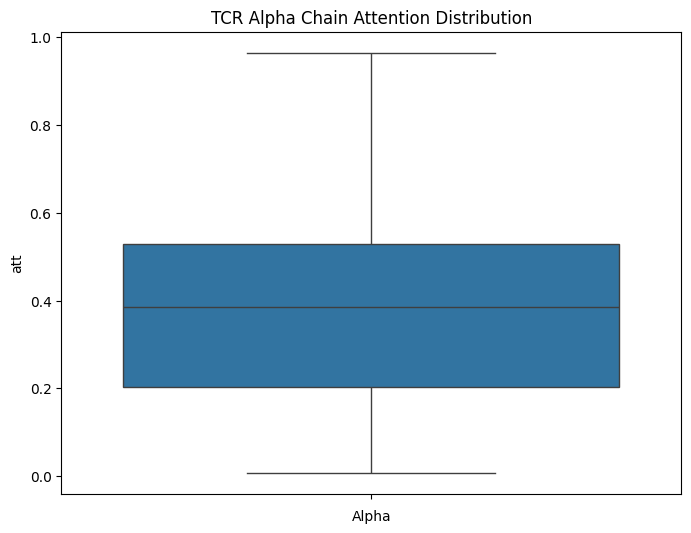

In [13]:
adata.obs['att'].min(), adata.obs['att'].max(), adata.obs['att'].median()
import matplotlib.pyplot as plt
import seaborn as sns

tcr_att = adata.obs['att'] # 随机生成示例数据

# 转换为 numpy 数组
tcr_att_values = tcr_att

# 绘制箱线图
plt.figure(figsize=(8, 6))
sns.boxplot(data=tcr_att_values)
plt.title("TCR Alpha Chain Attention Distribution")
plt.xlabel("Alpha")
plt.show()

/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


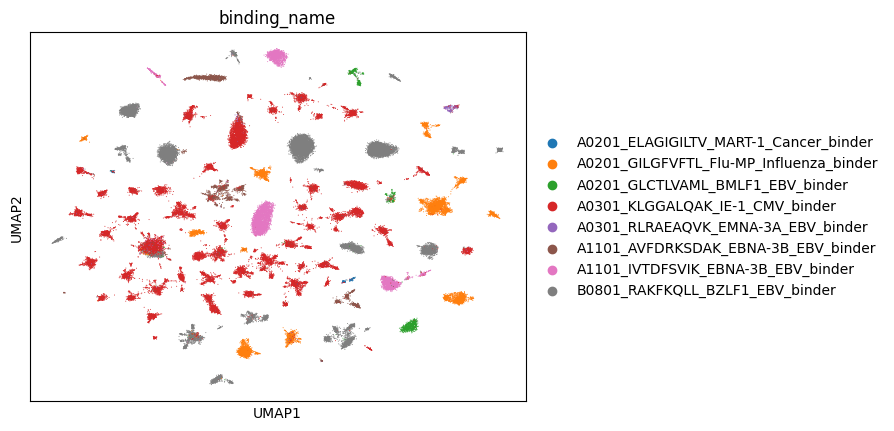

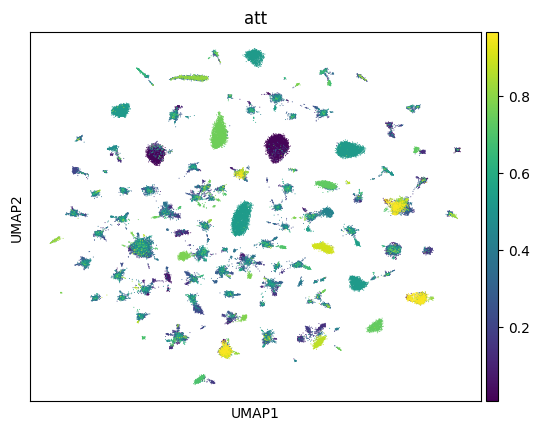

/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


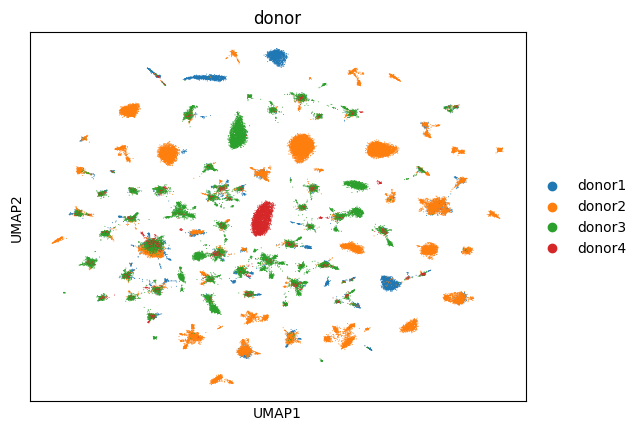

In [14]:
sc.pp.neighbors(adata, use_rep='h')
sc.tl.umap(adata)
sc.pl.umap(adata, color='binding_name', ncols=1)
sc.pl.umap(adata, color='att', ncols=1)
sc.pl.umap(adata, color='donor', ncols=1)

/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:392: UserWarning: Exited at iteration 586 with accuracies 
[1.41815114e-15 7.60349264e-06 2.19308879e-05 1.26084342e-05]
not reaching the requested tolerance 1.2829899787902832e-05.
Use iteration 391 instead with accuracy 
8.806981032358929e-06.

  _, diffusion_map = lobpcg(
/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:392: UserWarning: Exited postprocessing with accuracies 
[2.34690748e-15 2.77839882e-06 8.13200582e-06 2.43175195e-05]
not reaching the requested tolerance 1.2829899787902832e-05.
  _, diffusion_map = lobpcg(
/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


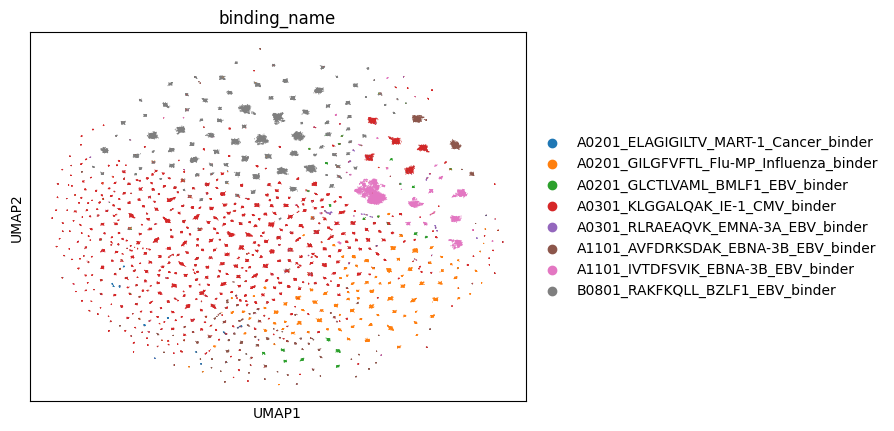

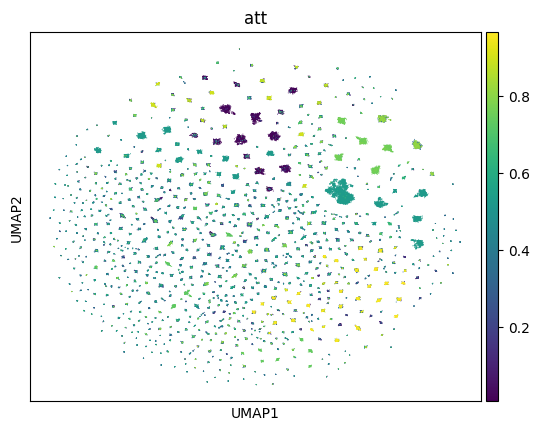

/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


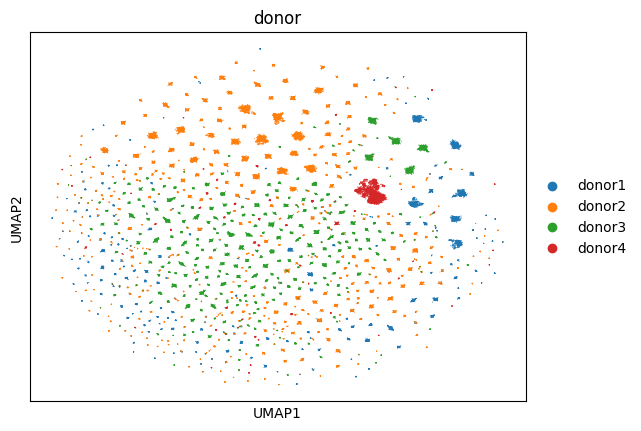

In [15]:
sc.pp.neighbors(adata, use_rep='z')
sc.tl.umap(adata)
sc.pl.umap(adata, color='binding_name', ncols=1)
sc.pl.umap(adata, color='att', ncols=1)
sc.pl.umap(adata, color='donor', ncols=1)

/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


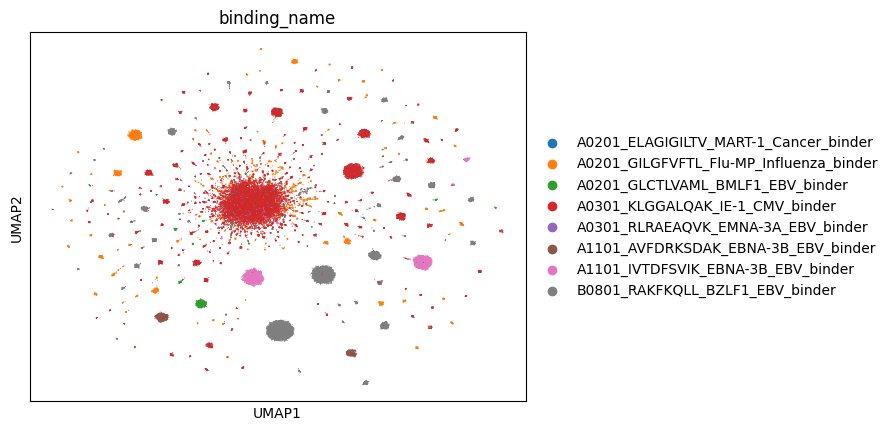

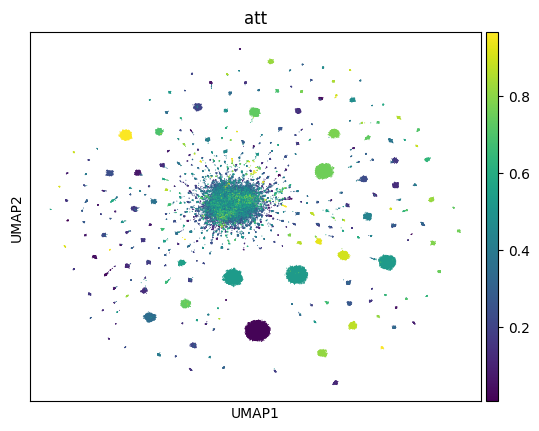

/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


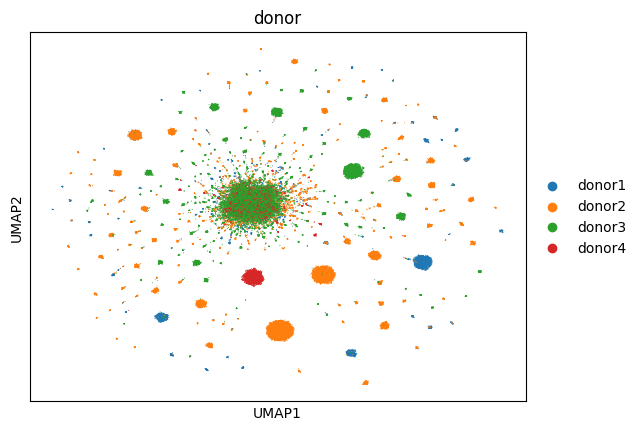

In [16]:
sc.pp.neighbors(adata, use_rep='htcr')
sc.tl.umap(adata)
sc.pl.umap(adata, color='binding_name', ncols=1)
sc.pl.umap(adata, color='att', ncols=1)
sc.pl.umap(adata, color='donor', ncols=1)

/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


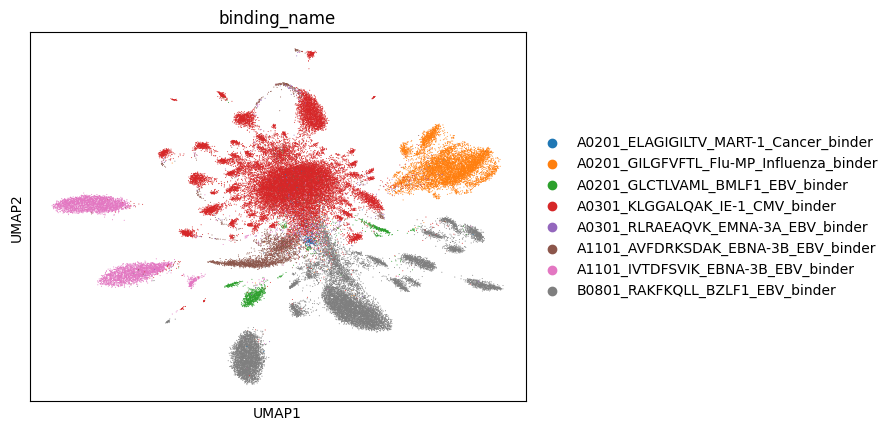

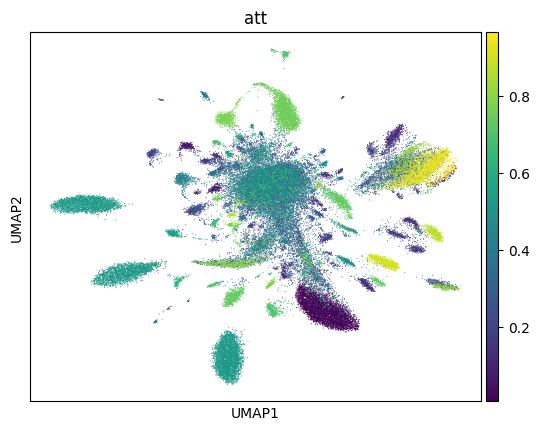

/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


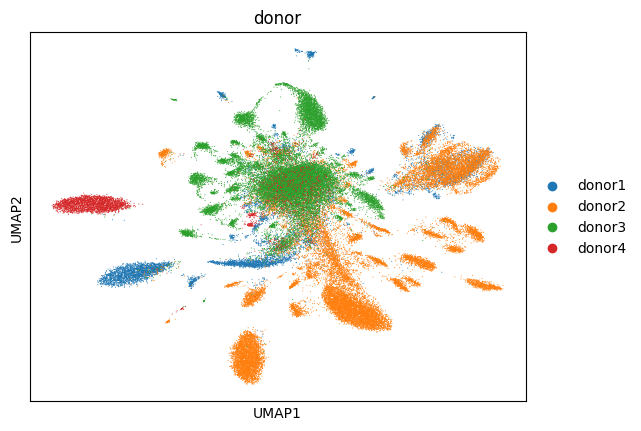

In [17]:
sc.pp.neighbors(adata, use_rep='crna')
sc.tl.umap(adata)
sc.pl.umap(adata, color='binding_name', ncols=1)
sc.pl.umap(adata, color='att', ncols=1)
sc.pl.umap(adata, color='donor', ncols=1)

/tmp/ipykernel_1720224/1182342249.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  latent_tmp.obs['clonotype'] = latent_tmp.obs['clonotype'].astype(str)
/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


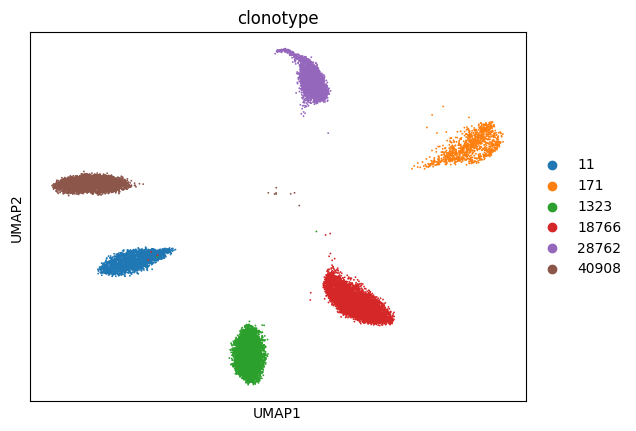

In [18]:
gil_cts_large = adata.obs['clonotype'].value_counts().head(6).index
latent_tmp = adata
latent_tmp = latent_tmp[latent_tmp.obs['clonotype'].isin(gil_cts_large)]
latent_tmp.obs['clonotype'] = latent_tmp.obs['clonotype'].astype(str)
sc.pl.umap(latent_tmp, color='clonotype', ncols=1)

/tmp/ipykernel_1720224/3753210379.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  latent_tmp.obs['clonotype'] = latent_tmp.obs['clonotype'].astype(str)
/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'clonotype'}, xlabel='UMAP1', ylabel='UMAP2'>

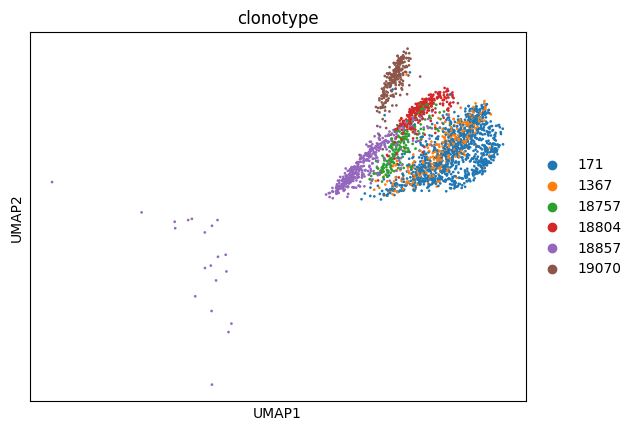

In [19]:
latent_gil = adata[adata.obs['binding_name']=='A0201_GILGFVFTL_Flu-MP_Influenza_binder']
gil_cts_large = latent_gil.obs['clonotype'].value_counts().head(6).index

latent_tmp = adata[adata.obs['binding_name']=='A0201_GILGFVFTL_Flu-MP_Influenza_binder']
latent_tmp = latent_tmp[latent_tmp.obs['clonotype'].isin(gil_cts_large)]
latent_tmp.obs['clonotype'] = latent_tmp.obs['clonotype'].astype(str)
sc.pl.umap(latent_tmp, color='clonotype', show=False, size=15)